---
# Examples of classifications using various SVM methods applied to the same dataset.
---

In this script, we show several examples of SVM classifications applied to a 2-D dataset made of two overlapping elliptical 
blobs. Each SVM method provides a realistic solution but, taken together, they quite differ in the details and
their classification performances.
 
We will compare the SVM performances with linear, polynomial, and radial-basis-functions (RBF) kernels.

SVM classifiers with nonlinear kernels perform well in problems with curvy or piecewise boundaries. Classical 
methods such as the linear discriminant analysis (LDA) and quadratic discriminant analysis (QDA) are more limited here since 
they are designed to tackle linear and quadratic boundaries between classes. 

The nonlinear SVM classifiers are often the most succesful ones and can generate solutions similar 
to their linear version when 'easy' datasets are involved. More often than not, the SVM-RBF classifier is the method
of choice with complex datasets. However, it can also generate chaotic looking results that are not robust to new data. 
We show several examples of this at the end of the script.


In [1]:
print(__doc__)

# Author: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: BSD

%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_blobs
from scipy import stats
import scipy as sp
import scipy.spatial
from scipy.spatial.distance import cdist

from numpy import unravel_index

import seaborn as sns
sns.set()

cm_dim = ListedColormap(['#FFAAAA', '#FFFFAA'])
cm_bright = ListedColormap(['#FF0000', '#FFFF00'])

# Used for reproductibility of the results
np.random.seed(42)

Automatically created module for IPython interactive environment


# Part I:  Generate the dataset

We use a dataset made of two overlapping ellipsoidal gaussian blobs.

In [2]:
# Number of datapoints in each cluster
N_samples = 150

# First gaussian 
center = [[0, 0]]
X, y = make_blobs(n_samples=N_samples, centers=center)
transformation = [[1, 0.2], [0.2, 1]]
X = np.dot(X, transformation)

# Second gaussian 
center = [[0, 0]]
X2, y2 = make_blobs(n_samples=N_samples, centers=center)
transformation = [[1, -0.5], [-0.5, 1]]
X2 = np.dot(X2, transformation) + [[2,2]]
y2 = y2 + 1

X = np.vstack((X, X2))
y = np.hstack((y, y2))


Normalize the data and generate a spatial grid where the class will be evaluated locally

In [3]:
nbins = 250

X = StandardScaler().fit_transform(X)
x_min = 1.1 * X[:,0].min()
x_max = 1.1 * X[:,0].max()
y_min = 1.1 * X[:,1].min()
y_max = 1.1 * X[:,1].max()

# Generate a spatial grid 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nbins), np.linspace(y_min, y_max, nbins))
Xgrid = np.c_[xx.ravel(), yy.ravel()]

Display the dataset

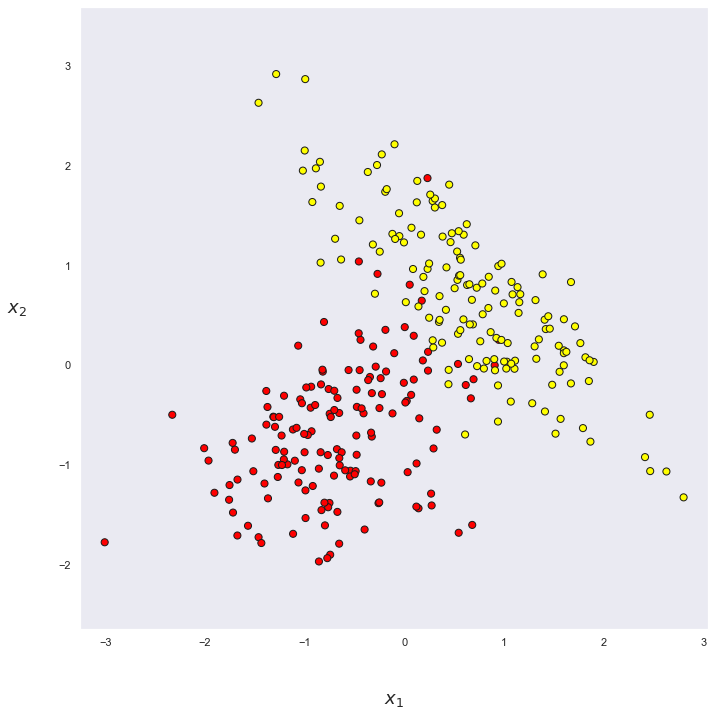

In [4]:
fig = plt.figure(figsize = (10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cm_bright, edgecolors='k')
ax = plt.gca()
ax.axis('equal')
ax.set_xlabel('$x_{1}$',fontsize=18)
ax.set_ylabel('$x_{2}$',rotation=0,fontsize=18)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.5)        
ax.grid(None)
fig.tight_layout()

plt.savefig('6.2.1_Overlapping_blobs_dataset.png')
plt.savefig('6.2.1_Overlapping_blobs_dataset.pdf')

Split the dataset into a training dataset (50 %) and a test dataset (50 %) 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,train_size=0.5)

# Part II: Function to display SVM classification results

There is so much boilerplate code required just to print the results that a nice function will do the work for us.

In [6]:
def display_classification_results(clf, X, y, Xgrid, xx, yy, figName):
    
    # Evaluate the discriminant function h(X) over the spatial grid
    xy = np.vstack([xx.ravel(), yy.ravel()]).T    
    h = clf.decision_function(xy).reshape(xx.shape)

    # Determine the class over the spatial grid
    Z = clf.predict(Xgrid) 
    Z = Z.reshape(xx.shape)


    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize = (15, 15))

    # ---- The first panel shows the data points with the SVM margin h(X) 
    ax1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cm_bright, edgecolors='k')

    # Display the margin h(X) = {-1, 0, +1}
    cs = ax1.contour(xx, yy, h, colors=['r', 'k', 'y'], levels=[-1, 0, 1], 
                    alpha=0.8, linestyles=['--', '-', '--'], linewidths=3)
    labels = ['$h(X)<0$', '$h(X)=0$', '$h(X)>0$']
    for i in range(len(labels)):
        cs.collections[i].set_label(labels[i])

    x_min, x_max, y_min, y_max = xx.min(), xx.max(), yy.min(), yy.max()
    ax1.set_xlim([x_min,x_max])
    ax1.set_ylim([y_min,y_max])
    ax1.set_xlabel('$x_{1}$', fontsize=14)
    ax1.set_ylabel('$x_{2}$', fontsize=14, rotation=0) 
    ax1.xaxis.set_label_coords(0.5, -0.05) 
    ax1.yaxis.set_label_coords(-0.05, 0.5) 
    ax1.set_aspect('equal')
    ax1.legend(loc="best")
    ax1.grid(None) 


    # ----- The second panel zooms on the central portion of the first panel and adds the support vectors
    ax2.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', edgecolors='k')

    # Display the margin h(X) = {-1, 0, +1}
    cs = ax2.contour(xx, yy, h, colors=['r', 'k', 'y'], levels=[-1, 0, 1], 
                    alpha=0.8, linestyles=['--', '-', '--'], linewidths=3)

    # Display the support vectors as circles around training data points
    ax2.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
               s=300, linewidth=1, facecolors='none',edgecolors='k');       

    ax2.set_xlim([-1,2])
    ax2.set_ylim([-1,1.5])
    ax2.set_xlabel('$x_{1}$', fontsize=14)
    ax2.set_ylabel('$x_{2}$', fontsize=14, rotation=0) 
    ax2.xaxis.set_label_coords(0.5, -0.05) 
    ax2.yaxis.set_label_coords(-0.05, 0.5) 
    ax2.set_aspect('equal')
    ax2.grid(None)  

    
    # ----- The third panel shows the influence zone of each class; the boundary is where h(X)=0
    ax3.pcolormesh(xx, yy, Z, cmap=cm_dim, norm=colors.Normalize(0., 1.), zorder=0) 
    ax3.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')


    x_min, x_max, y_min, y_max = xx.min(), xx.max(), yy.min(), yy.max()
    ax3.set_xlim([x_min,x_max])
    ax3.set_ylim([y_min,y_max])
    ax3.set_xlabel('$x_{1}$', fontsize=14)
    ax3.set_ylabel('$x_{2}$', fontsize=14, rotation=0) 
    ax3.xaxis.set_label_coords(0.5, -0.05) 
    ax3.yaxis.set_label_coords(-0.05, 0.5) 
    ax3.set_aspect('equal')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.grid(None)  

    # --- The fourth panel is hidden
    ax4.set_visible(False)

    fig.tight_layout()

    plt.savefig(figName + '.png')
    plt.savefig(figName + '.pdf')

# Part III: 

## Linear SVM classification

The linear SVM classifier has a free parameter C controlling the extent the support vectors can spread into the margin. 
We must determine, using cross validation, which value of C maximizes the performance of the SVM classifier on the dataset.  

In [7]:
# Grid of logarithmic values of C
C = np.logspace(-5,5,11, endpoint=True)

score = np.zeros(C.shape)
for i, c in enumerate(C):
    # Train the classifier on the training dataset for a given c value 
    model = SVC(kernel='linear', C=c)
    clf = model.fit(X_train, y_train)

    # Measure the score of the classifier on the testing dataset
    score[i] = clf.score(X_test, y_test)
    
# Find the value of C that maximizes the classification score
indx = np.argmax(score)
c = C[indx]


Display the score

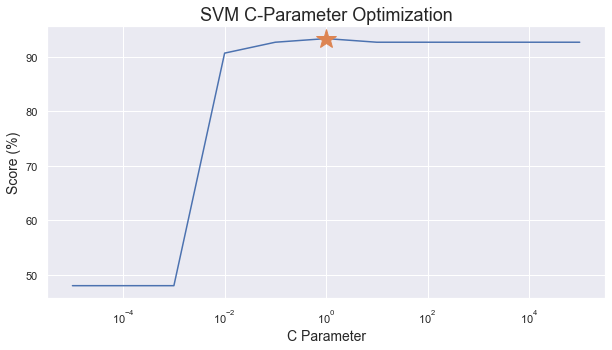

Maximum score = 93.3 %


In [8]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(C, 100*score, c, 100*score[indx],'*', markersize=20)
ax.set_xlabel('C Parameter',fontsize=14)
ax.set_ylabel('Score (%)',fontsize=14)
ax.set_xscale('log')
ax.xaxis.grid(True, which='major')
ax.set_title('SVM C-Parameter Optimization',fontsize=18)
plt.show()

print('Maximum score = %.1f %%' % (100*score[indx]))

Train the classifier using the full dataset with the optimal C value

In [9]:
model = SVC(kernel='linear', C=c)
clf = model.fit(X, y) 

The left panel shows the complete dataset with the linear SVM margin. The second panels 
shows a closeup on the central region where the two clusters overlap. The support vectors appear as large circles. 
The last panel shows the influence zone of each class; the boundary is defined by $h(X)=0$.  

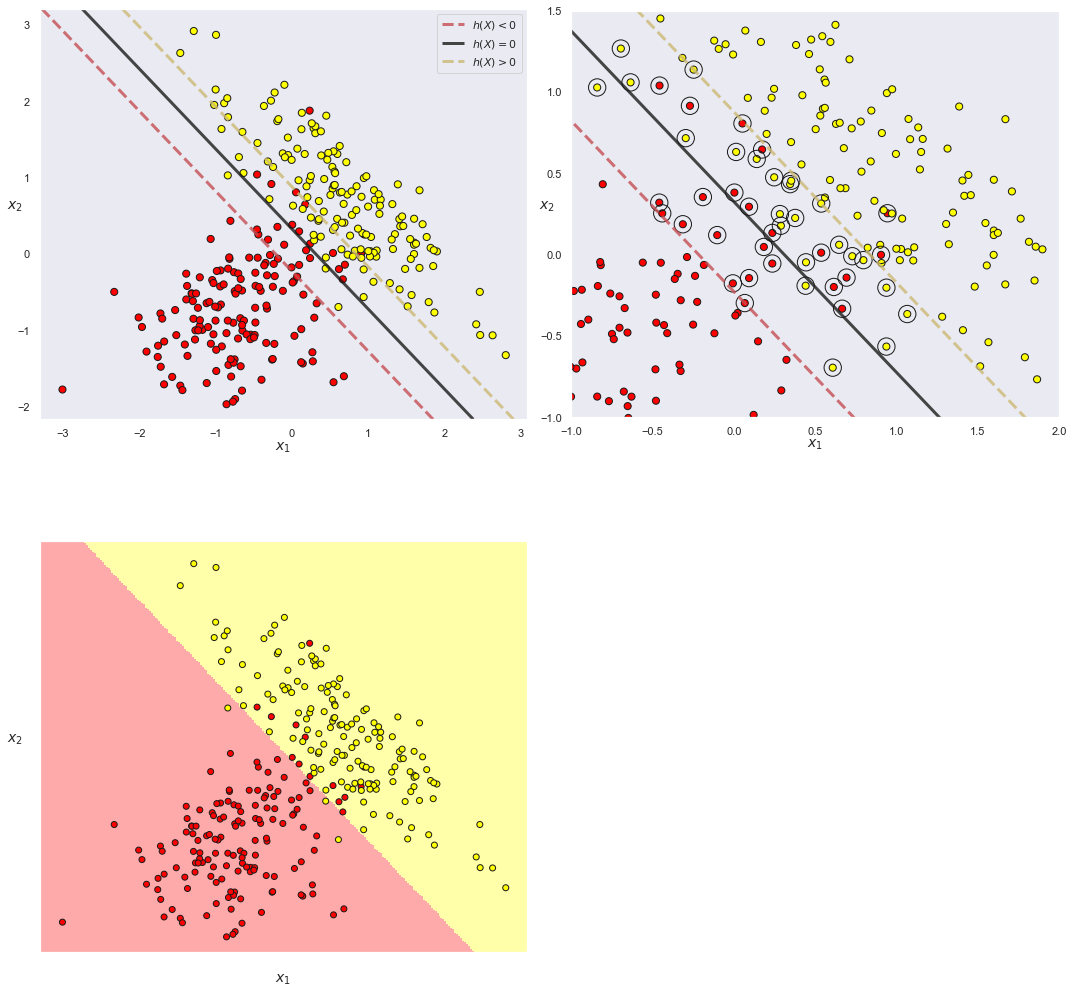

In [10]:
display_classification_results(clf, X, y, Xgrid, xx, yy, figName='6.2.2_SVM_linear_classification_of_overlapping_blobs')


## SVM classification with a polynomial kernel of degree 3

This SVM classifier also has the free parameter C. It is optimized using the same method as before 

In [11]:
# Grid of logarithmic values of C
C = np.logspace(-5,5,11, endpoint=True)

score = np.zeros(C.shape)
for i, c in enumerate(C):
    # Train the classifier on the training dataset for a given c value 
    model = SVC(kernel='poly',degree=3, C=c)
    clf = model.fit(X_train, y_train)

    # Measure the score of the classifier on the testing dataset
    score[i] = clf.score(X_test, y_test)
    
# Find the value of C that maximizes the classification score
indx = np.argmax(score)
c = C[indx]    

Display the score

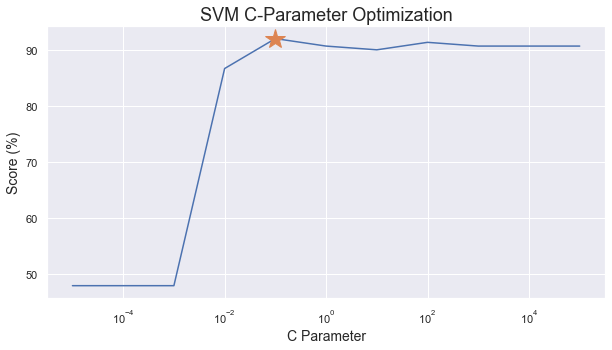

Maximum score = 92.0 %


In [12]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(C, 100*score, c, 100*score[indx],'*', markersize=20)
ax.set_xlabel('C Parameter',fontsize=14)
ax.set_ylabel('Score (%)',fontsize=14)
ax.set_xscale('log')
ax.xaxis.grid(True, which='major')
ax.set_title('SVM C-Parameter Optimization',fontsize=18)
plt.show()

print('Maximum score = %.1f %%' % (100*score[indx]))

Train the classifier using the full dataset with the optimal C value

In [13]:
model = SVC(kernel='poly',degree=3, C=c)
clf = model.fit(X, y)

The new SVM boundary $h(X)=0$ is more complex than the last one and better separates the two clusters. It is linear 
in the outer regions and curved where the two clusters merge. 

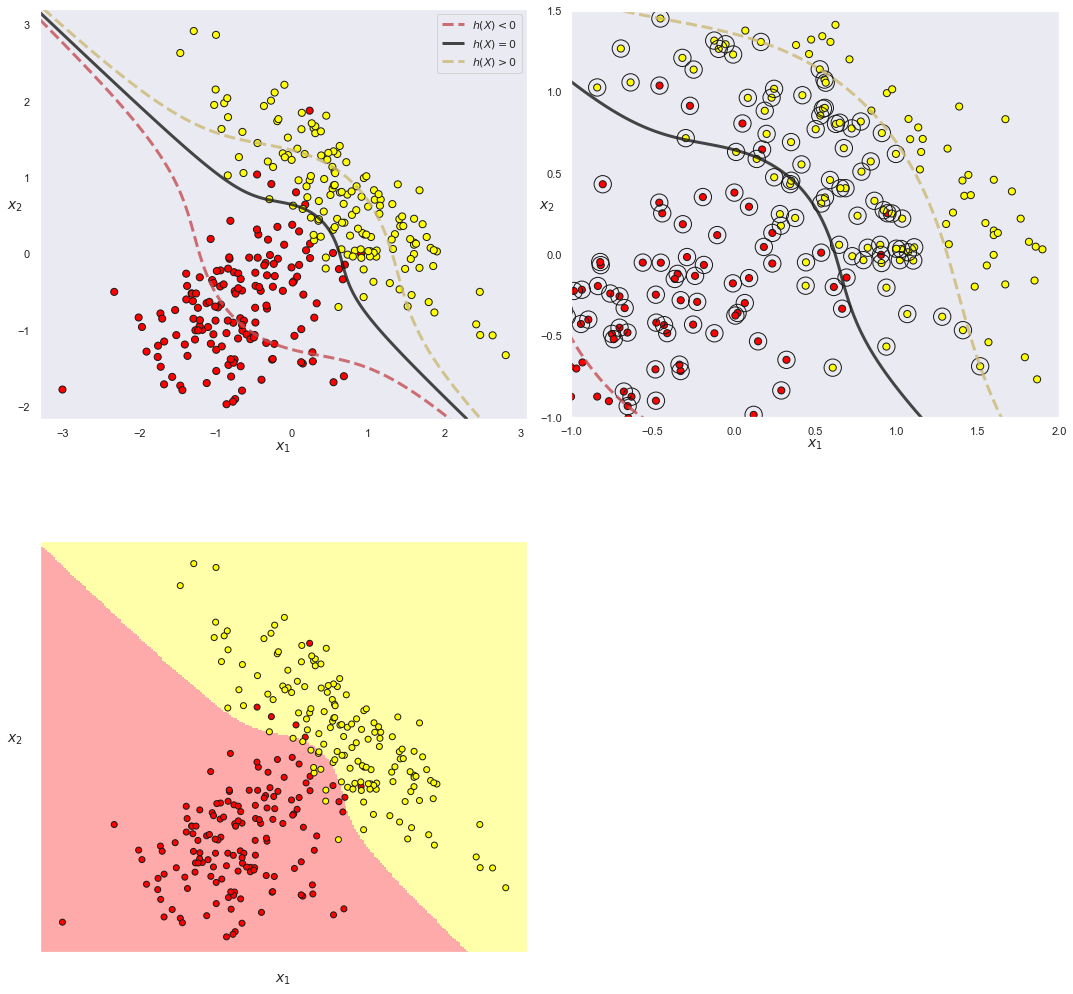

In [14]:
display_classification_results(clf, X, y, Xgrid, xx, yy, figName='6.2.3_SVM_polynomial_classification_of_overlapping_blobs')

## SVM classification with radial basis functions

This classifier has two free parameters, C and gamma, that must be evaluated on the dataset. The gamma parameter is 
related to the scale length of the RBF. 

We use a grid method to evaluate the best parameter values. 


In [15]:
# Find the nearest distance between any training point
distances = cdist(X_train, X_train, 'euclidean')

# An element is not its own nearest neighbor
np.fill_diagonal(distances, sp.inf)

# Find the smallest distance overall between training values. This is the minimum
# spatial scale for the radial basis functions
sigma_min = distances.min()    

# Define (C,gamma) grid parameters
gammas = np.array([1, 2, 4, 8, 16, 32, 64, 128, 256])*sigma_min
C = np.logspace(-5,5,11)    


# Get the classification score at each point of the parameter grid
score = np.zeros([C.shape[0], gammas.shape[0]])
for i, c in enumerate(C):
    for j, gamma in enumerate(gammas):
        # Define the model with the selected set of parameters. We take into account 
        # that the training set may not be balanced.
        model = SVC(kernel='rbf', C=c, gamma=gamma, class_weight='balanced')

        # Train the model
        clf = model.fit(X_train, y_train)

        # Test the model to get its classification score
        score[i,j] = clf.score(X_test, y_test)


# Get the model with the best score
(i,j) = unravel_index(np.argmax(score),score.shape)
c = C[i]
gamma = gammas[j]

print('Maximum score = %.1f %%' % (100*score[i,j]))


Maximum score = 94.7 %


Train the classifier using the full dataset with the optimal C and gamma values

In [16]:
model = SVC(kernel='rbf', C=c, gamma=gamma)
clf = model.fit(X, y)

The decision boundary $h(X)=0$ is similar in shape to the previous one. The shape and the width of the margin 
are quite different however. The margin is narrower in the zone where the two clusters overlap. It is also the 
classifier with the highest score overall.


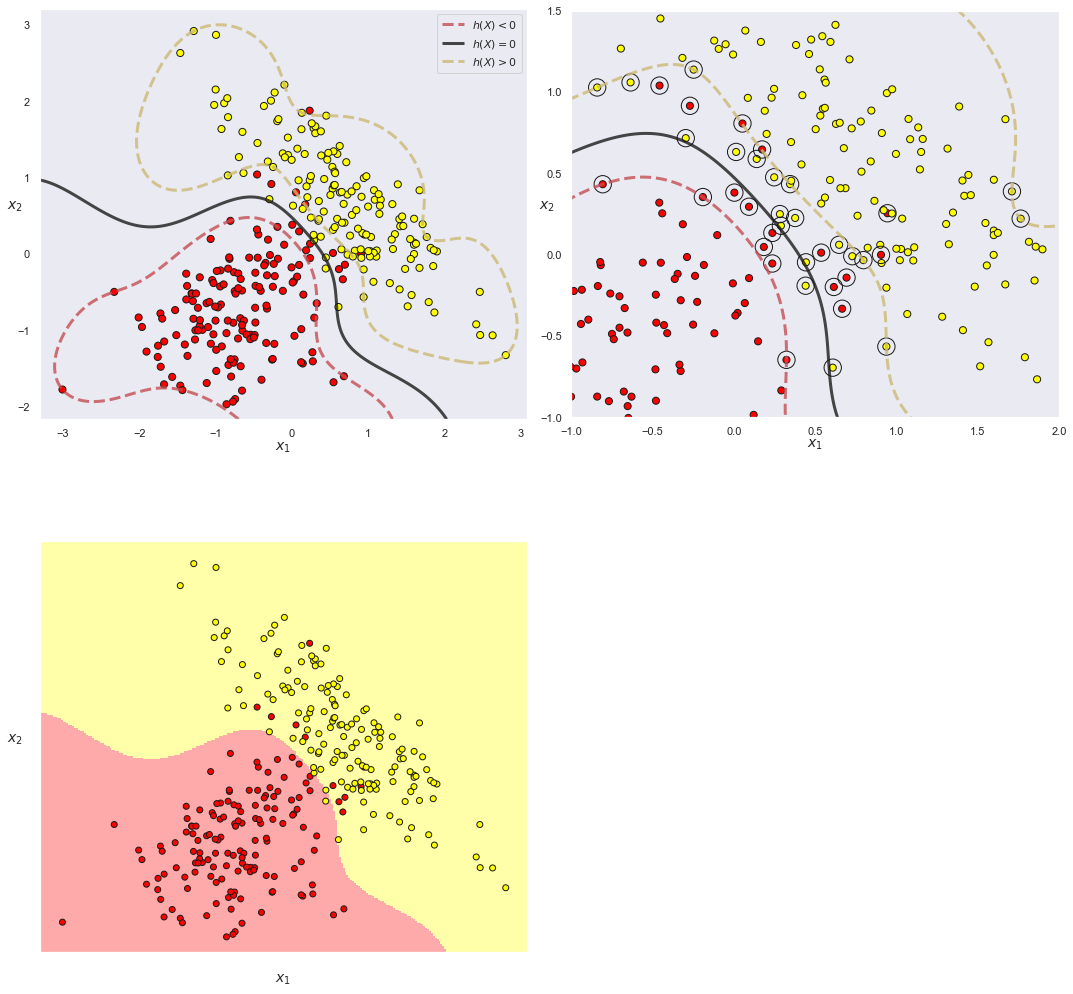

In [17]:
display_classification_results(clf, X, y, Xgrid, xx, yy, figName='6.2.4_SVM_RBF_classification_of_overlapping_blobs')

## How does the scale parameter gamma affect the results? 

The SVM classifier with the RBF kernel is well known to produce solutions when the data points cannot be 
separated in two classes using a line in 2D, a plane in 3D, etc.

However good the solutions may be, they can vary considerably with the scale parameter gamma. Hence, the boundaries 
can range from linear to lightly curved to highly convoluted. The last solutions are often 'catastrophic' and unusable.
This sometimes makes the analysis of data difficult since the classification does not help to understand the 
hidden underlying structure.  

In what follows, we show some solutions to the previous dataset with the same value of the C parameter but with 
different values of gamma. Notice how they change the picture we get. 

### Case 1: using a value of gamma 64 times smaller than the optimal one
    
The boundary is almost linear with open $h(X)$ curves. It is not very different from the linear SVM solution we shown. 
The support vectors are also similar.

gamma/gamma_{opt} = 0.015625   Maximum score = 92.7 %


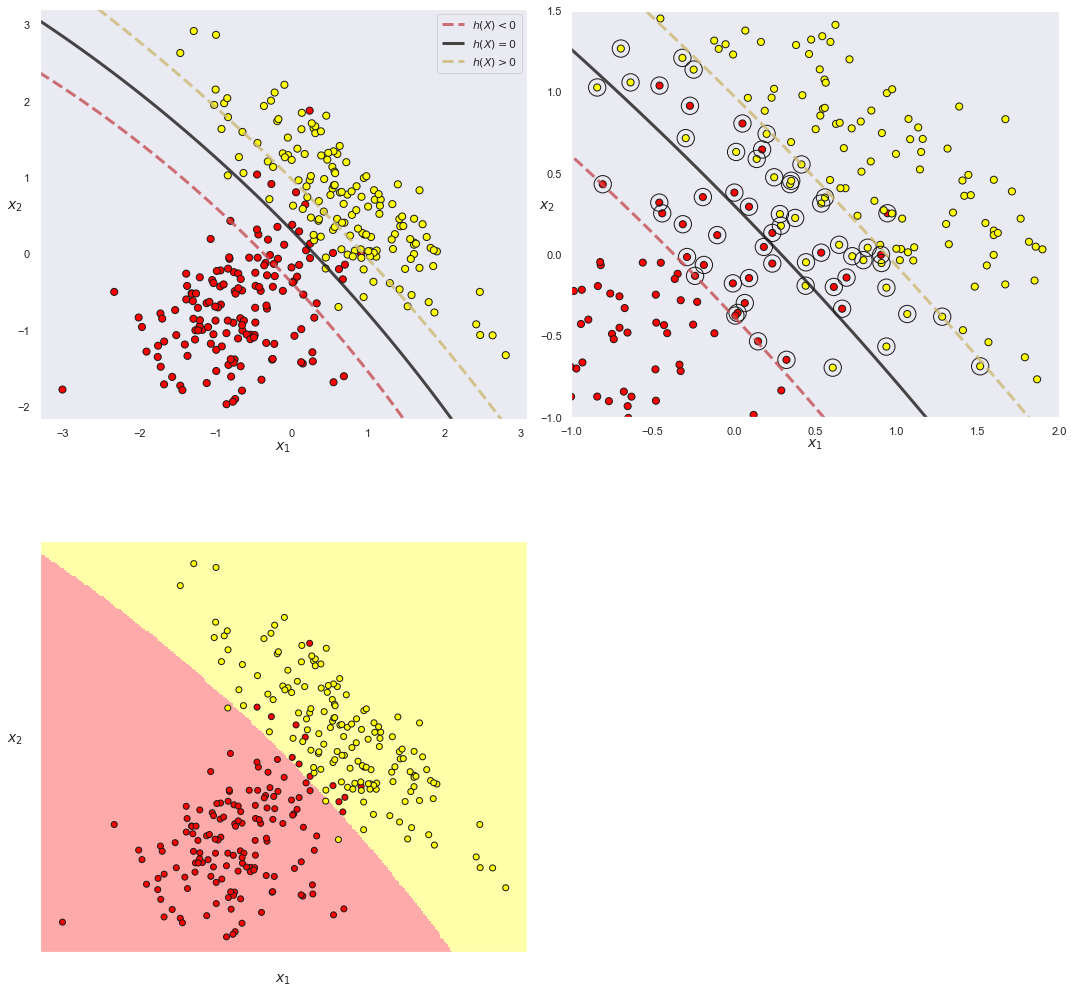

In [18]:
k = j-6
model = SVC(kernel='rbf', C=c, gamma=gammas[k])
clf = model.fit(X, y)
display_classification_results(clf, X, y, Xgrid, xx, yy, 
                               figName='6.2.5_SVM_RBF_classification_of_overlapping_blobs_large_gamma')

print('gamma/gamma_{opt} = %f   Maximum score = %.1f %%' % (gammas[k]/gamma, 100*score[i,k]))

### Case 2: using a value of gamma 4 times larger than the optimal one
    
The margin curves are chaotic and contain inner closed curves! The boundary curve $h(x)=0$ is also quite different from 
what was found in the last two examples. 

Take-home message: we should always use cross validation to find the best solution based on the available data. 
Choosing a result just by looking at those wigly curves is sure to lead us to error!

gamma/gamma_{opt} = 4.000000   Maximum score = 92.7 %


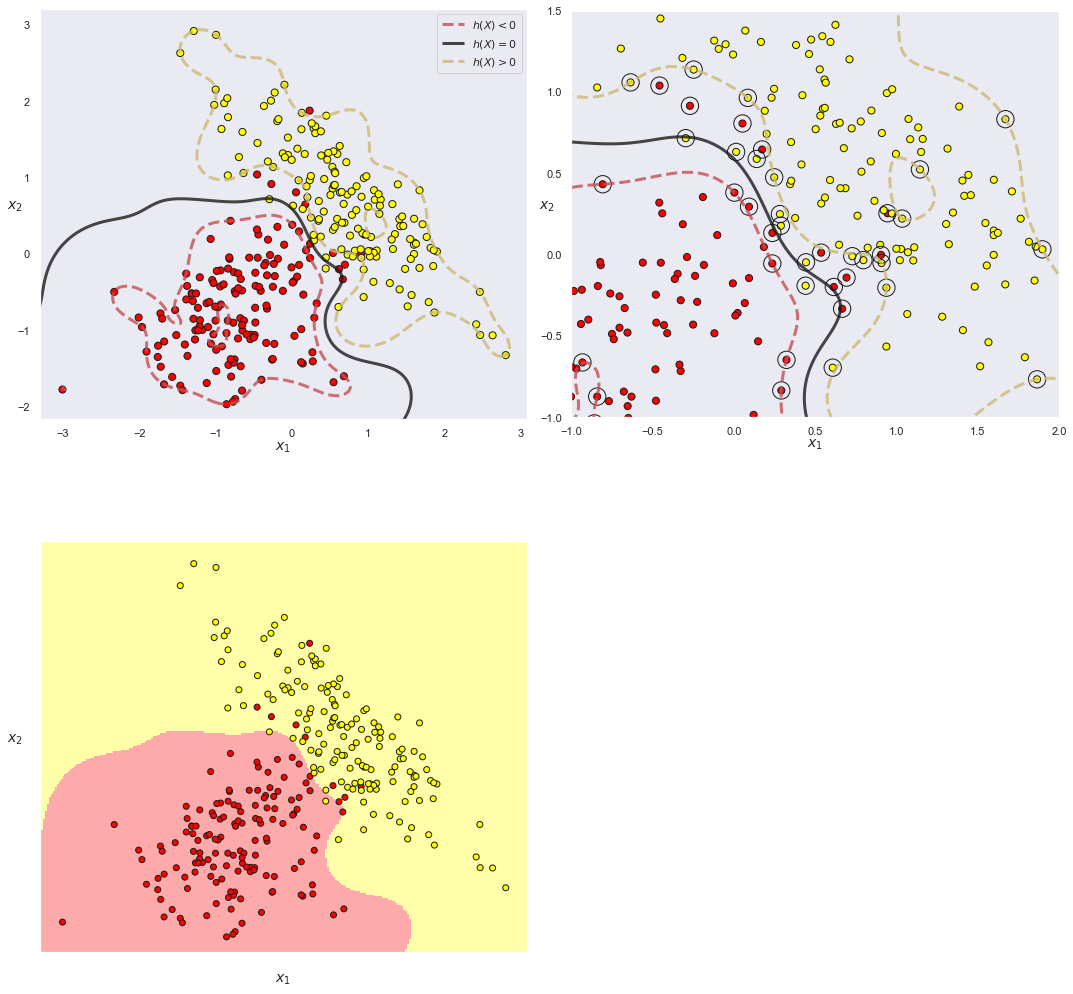

In [19]:
jj = j+2
model = SVC(kernel='rbf', C=c, gamma=gammas[jj])
clf = model.fit(X, y)
display_classification_results(clf, X, y, Xgrid, xx, yy, 
                               figName='6.2.6_SVM_RBF_classification_of_overlapping_blobs_small_gamma')

print('gamma/gamma_{opt} = %f   Maximum score = %.1f %%' % (gammas[jj]/gamma, 100*score[i,jj]))